# Myers-Briggs Type Indicator Using Deep Learning (Natural Language Processing)

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import torch
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    Trainer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

In [3]:
# Import dataset
mbti_df = pd.read_csv("mbti_1.csv")

In [3]:
mbti_counts = mbti_df['type'].value_counts()
mbti_counts

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

## Data Visualization

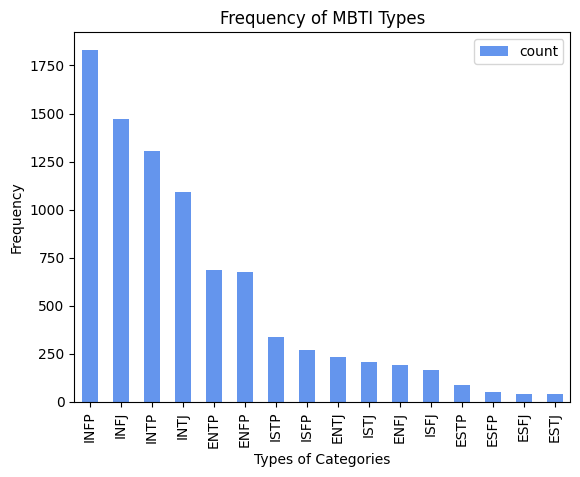

In [ ]:
# Generate the graph of Frequency of MBTI Types
mbti_counts = mbti_df['type'].value_counts()
plt.figure(figsize=(6, 3))
pd.DataFrame(mbti_df.type.value_counts()).plot.bar(color='#6495ED')
plt.ylabel('Frequency')
plt.xlabel('Types of Categories')
plt.title('Frequency of MBTI Types')
plt.show()

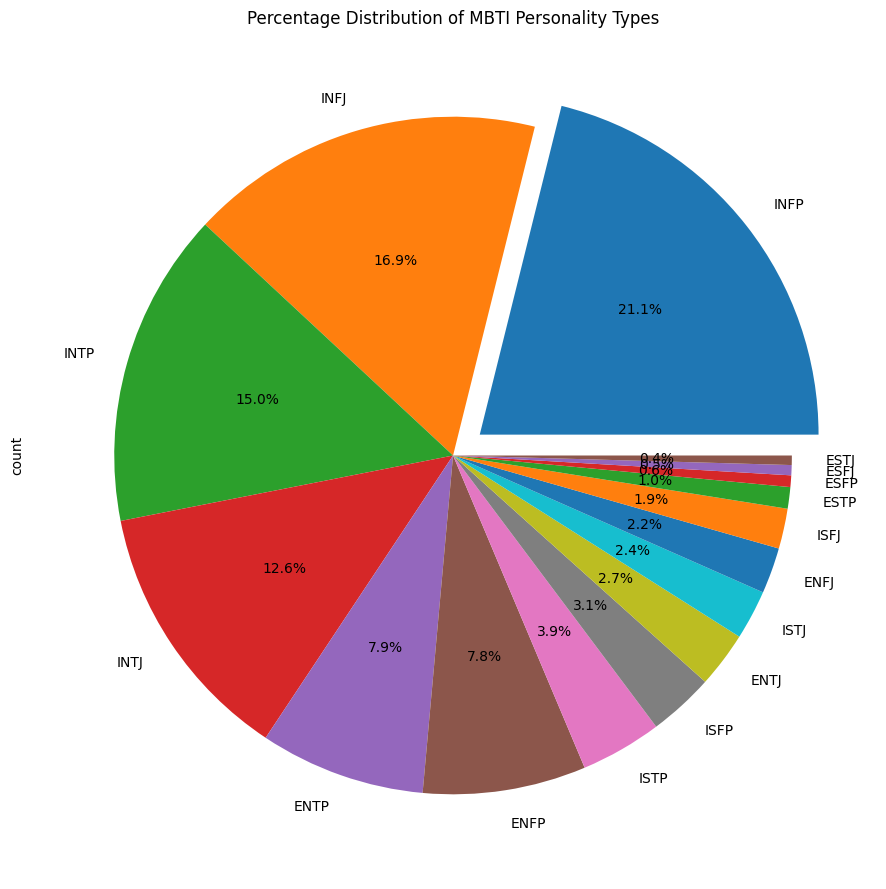

In [ ]:
mbti_df.type.value_counts().plot(kind='pie',figsize=(11,11), autopct='%1.1f%%', explode=[0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Percentage Distribution of MBTI Personality Types')
plt.show()

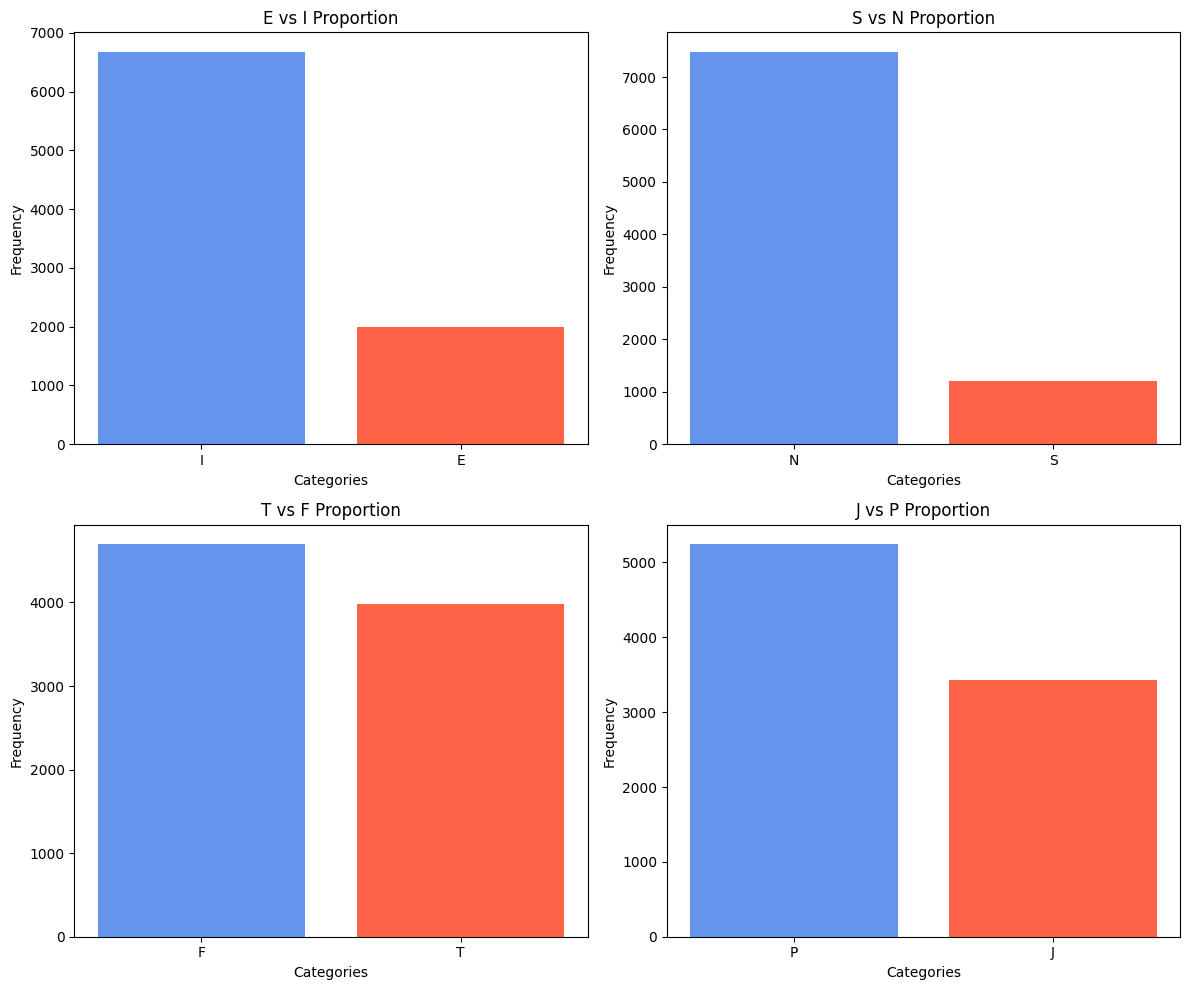

In [ ]:
mbti_df['EI'] = mbti_df['type'].apply(lambda x: 'E' if x[0] == 'E' else 'I')
mbti_df['SN'] = mbti_df['type'].apply(lambda x: 'S' if x[1] == 'S' else 'N')
mbti_df['TF'] = mbti_df['type'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
mbti_df['JP'] = mbti_df['type'].apply(lambda x: 'J' if x[3] == 'J' else 'P')

dimensions = ['EI', 'SN', 'TF', 'JP']
dimension_titles = ['E vs I', 'S vs N', 'T vs F', 'J vs P']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, dim in enumerate(dimensions):
    counts = mbti_df[dim].value_counts()
    axes[i].bar(counts.index, counts.values, color=['#6495ED', '#FF6347'])
    axes[i].set_title(f'{dimension_titles[i]} Proportion')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Categories')

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
# to convert text in posts to lowercase
mbti_df["posts"] = mbti_df["posts"].str.lower()

# to remove web links from the posts content
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', ' ', x))

# to remove numbers, special characters, underscores, and plus signs, leaving only clean text with spaces.
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: re.sub(r'[0-9]', ' ', x))
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: re.sub(r'[_+\W]+', ' ', x))

# to normalize the text by ensuring consistent spacing
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# to remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# to implement lemmetization i.e. to group together different forms of a word
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
mbti_df["posts"] = mbti_df["posts"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

# to replace the word in posts with its synonym from WordNet to add variety to the text or enhance its semantic representation
from nltk.corpus import wordnet

def get_synonym(word):
    syns = wordnet.synsets(word)
    if syns:
        return syns[0].lemmas()[0].name()
    return word

mbti_df["posts"] = mbti_df["posts"].apply(lambda x: " ".join([get_synonym(word) for word in x.split()]))

# Add columns for each MBTI dimension
mbti_df['IE'] = mbti_df['type'].apply(lambda x: x[0])
mbti_df['NS'] = mbti_df['type'].apply(lambda x: x[1])
mbti_df['TF'] = mbti_df['type'].apply(lambda x: x[2])
mbti_df['JP'] = mbti_df['type'].apply(lambda x: x[3])

In [ ]:
# Get device
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

## LSTM

In [ ]:
# Define the list of dimensions to classify
dimensions = ['IE', 'NS', 'TF', 'JP']

# Hyperparameters
max_words = 5000  
max_len = 300  
embedding_dim = 128  

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(mbti_df['posts'])

# Iterate over each dimension and classify
for dim in dimensions:
    print(f"--- Classification for Dimension: {dim} ---")

    posts = mbti_df['posts']
    labels = mbti_df[dim]

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = np.array(labels_encoded)

    train_post, test_post, train_target, test_target = train_test_split(
        posts, labels_encoded, test_size=0.2, random_state=42
    )

    train_sequences = tokenizer.texts_to_sequences(train_post)
    test_sequences = tokenizer.texts_to_sequences(test_post)

    train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

    # Build the LSTM model
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(
        train_padded, train_target,
        validation_data=(txest_padded, test_target),
        epochs=5, batch_size=32, verbose=2
    )

    # Make predictions on the test set
    predictions = model.predict(test_padded).flatten()
    pred_labels = (predictions > 0.5).astype(int)

    print("Classification Report:\n",
          classification_report(test_target, pred_labels, target_names=label_encoder.classes_))


--- Classification for Dimension: IE ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
217/217 - 12s - 53ms/step - accuracy: 0.7666 - loss: 0.5569 - val_accuracy: 0.7775 - val_loss: 0.5342
Epoch 2/5
217/217 - 4s - 17ms/step - accuracy: 0.7716 - loss: 0.5047 - val_accuracy: 0.7746 - val_loss: 0.5494
Epoch 3/5
217/217 - 3s - 13ms/step - accuracy: 0.8205 - loss: 0.4047 - val_accuracy: 0.7637 - val_loss: 0.6083
Epoch 4/5
217/217 - 4s - 16ms/step - accuracy: 0.8749 - loss: 0.2994 - val_accuracy: 0.7556 - val_loss: 0.6911
Epoch 5/5
217/217 - 4s - 20ms/step - accuracy: 0.9239 - loss: 0.1928 - val_accuracy: 0.6997 - val_loss: 0.9896
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           E       0.29      0.25      0.27       382
           I       0.80      0.83      0.81      1353

    accuracy                           0.70      1735
   macro avg       0.54      0.54      0.54      1735
weighted avg       0.68      0.70      0.69      1735

--- Classification for Dimension: NS ---
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


217/217 - 6s - 28ms/step - accuracy: 0.8579 - loss: 0.4322 - val_accuracy: 0.8582 - val_loss: 0.4109
Epoch 2/5
217/217 - 4s - 20ms/step - accuracy: 0.8634 - loss: 0.3877 - val_accuracy: 0.8530 - val_loss: 0.4312
Epoch 3/5
217/217 - 3s - 13ms/step - accuracy: 0.8793 - loss: 0.3117 - val_accuracy: 0.8259 - val_loss: 0.4777
Epoch 4/5
217/217 - 3s - 14ms/step - accuracy: 0.9108 - loss: 0.2275 - val_accuracy: 0.7810 - val_loss: 0.5710
Epoch 5/5
217/217 - 4s - 16ms/step - accuracy: 0.9427 - loss: 0.1608 - val_accuracy: 0.8086 - val_loss: 0.6648
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           N       0.86      0.93      0.89      1489
           S       0.16      0.09      0.11       246

    accuracy                           0.81      1735
   macro avg       0.51      0.51      0.50      1735
weighted avg       0.76      0.81      0.78      1735

--- Classification for Dimension: TF ---
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


217/217 - 6s - 26ms/step - accuracy: 0.5487 - loss: 0.6872 - val_accuracy: 0.5683 - val_loss: 0.6807
Epoch 2/5
217/217 - 4s - 18ms/step - accuracy: 0.6130 - loss: 0.6633 - val_accuracy: 0.5493 - val_loss: 0.6854
Epoch 3/5
217/217 - 5s - 24ms/step - accuracy: 0.7073 - loss: 0.5852 - val_accuracy: 0.5965 - val_loss: 0.7066
Epoch 4/5
217/217 - 3s - 15ms/step - accuracy: 0.7902 - loss: 0.4688 - val_accuracy: 0.6352 - val_loss: 0.7477
Epoch 5/5
217/217 - 5s - 23ms/step - accuracy: 0.8607 - loss: 0.3456 - val_accuracy: 0.6046 - val_loss: 0.8978
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           F       0.62      0.71      0.66       937
           T       0.58      0.48      0.53       798

    accuracy                           0.60      1735
   macro avg       0.60      0.60      0.59      1735
weighted avg       0.60      0.60      0.60      1735

--- Classification for Dimension: JP ---
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


217/217 - 6s - 27ms/step - accuracy: 0.6009 - loss: 0.6745 - val_accuracy: 0.6144 - val_loss: 0.6703
Epoch 2/5
217/217 - 3s - 13ms/step - accuracy: 0.6290 - loss: 0.6438 - val_accuracy: 0.5850 - val_loss: 0.6955
Epoch 3/5
217/217 - 3s - 13ms/step - accuracy: 0.7362 - loss: 0.5400 - val_accuracy: 0.5251 - val_loss: 0.7832
Epoch 4/5
217/217 - 6s - 27ms/step - accuracy: 0.8258 - loss: 0.3985 - val_accuracy: 0.5735 - val_loss: 0.9500
Epoch 5/5
217/217 - 3s - 15ms/step - accuracy: 0.8945 - loss: 0.2717 - val_accuracy: 0.5280 - val_loss: 1.2173
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           J       0.40      0.45      0.42       669
           P       0.63      0.58      0.60      1066

    accuracy                           0.53      1735
   macro avg       0.51      0.51      0.51      1735
weighted avg       0.54      0.53      0.53      1735



## Preparation

In [20]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom dataset class
class MBTIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary", zero_division=1)
    precision = precision_score(labels, preds, average="binary", zero_division=1)
    recall = recall_score(labels, preds, average="binary", zero_division=1)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
    
# Split text into chunks
def split_text_into_chunks(text, tokenizer, max_length=128):
    tokens = tokenizer.tokenize(text)
    chunk_size = max_length - 2
    chunks = [tokens[i:i+chunk_size] for i in range(0, len(tokens), chunk_size)]
    chunk_texts = [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]
    return chunk_texts

## Baseline Model

In [21]:
# Baseline model with BERT embeddings
def train_baseline_model(train_data, test_data, train_labels, test_labels, label_encoder, dimension):
    print(f"\nTraining Logistic Regression on BERT embeddings for {dimension} dimension...")

    bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
    bert_model.eval()

    def get_embeddings(text_data):
        embeddings = []
        batch_size = 16
        for i in range(0, len(text_data), batch_size):
            batch_texts = text_data[i:i+batch_size].tolist()
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=128
            ).to(device)
            with torch.no_grad():
                outputs = bert_model(**inputs)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)
        embeddings = np.concatenate(embeddings, axis=0)
        return embeddings


    # Get embeddings for train and test data
    train_embeddings = get_embeddings(train_data)
    test_embeddings = get_embeddings(test_data)

    # Train logistic regression model on embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(train_embeddings, train_labels)

    # Predictions
    preds = lr_model.predict(test_embeddings)

    # Evaluation
    accuracy = accuracy_score(test_labels, preds)
    f1 = f1_score(test_labels, preds, average="binary", zero_division=1)
    precision = precision_score(test_labels, preds, average="binary", zero_division=1)
    recall = recall_score(test_labels, preds, average="binary", zero_division=1)
    print(f"BERT Embeddings + Logistic Regression Results for {dimension} dimension:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Classification report
    report = classification_report(test_labels, preds, target_names=label_encoder.classes_, zero_division=1)
    print(f"\nClassification Report for BERT Embeddings + Logistic Regression Model ({dimension} dimension):\n", report)

## Bert Model

In [22]:
# Function to train and evaluate BERT model for each MBTI dimension
def train_bert_model(train_data, test_data, train_labels, test_labels, dimension, label_encoder, num_epochs=3):
    print(f"\nTraining Fine-Tuned BERT model for {dimension} dimension...")
    train_chunks = []
    train_chunk_labels = []
    train_chunk_orig_indices = []

    for idx, (text, label) in enumerate(zip(train_data, train_labels)):
        chunks = split_text_into_chunks(text, tokenizer, max_length=128)
        train_chunks.extend(chunks)
        train_chunk_labels.extend([label]*len(chunks))
        train_chunk_orig_indices.extend([idx]*len(chunks))

    test_chunks = []
    test_chunk_labels = []
    test_chunk_orig_indices = []

    for idx, (text, label) in enumerate(zip(test_data, test_labels)):
        chunks = split_text_into_chunks(text, tokenizer, max_length=128)
        test_chunks.extend(chunks)
        test_chunk_labels.extend([label]*len(chunks))
        test_chunk_orig_indices.extend([idx]*len(chunks))

    # Tokenization and encoding
    train_encodings = tokenizer(
        train_chunks,
        truncation=True,
        padding=True,
        max_length=128
    )

    test_encodings = tokenizer(
        test_chunks,
        truncation=True,
        padding=True,
        max_length=128
    )

    # Create datasets
    train_dataset = MBTIDataset(train_encodings, train_chunk_labels)
    test_dataset = MBTIDataset(test_encodings, test_chunk_labels)

    # Load model for binary classification
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)

    # Adjust hyperparameters
    training_args = TrainingArguments(
        output_dir=f'./results_{dimension}',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        logging_dir=f'./logs_{dimension}',
        logging_steps=100,
        learning_rate=2e-5,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        fp16=False,
        dataloader_num_workers=0,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    # Fine-tune BERT model
    trainer.train()

    # Evaluate the BERT model
    preds_output = trainer.predict(test_dataset)
    preds = preds_output.predictions.argmax(-1)

    preds_per_text = defaultdict(list)
    labels_per_text = {}

    for idx, pred, label in zip(test_chunk_orig_indices, preds, test_chunk_labels):
        preds_per_text[idx].append(pred)
        labels_per_text[idx] = label

    # Compute the final prediction
    final_preds = []
    final_labels = []
    for idx in preds_per_text.keys():
        chunk_preds = preds_per_text[idx]
        # Majority voting
        final_pred = max(set(chunk_preds), key=chunk_preds.count)
        final_preds.append(final_pred)
        final_labels.append(labels_per_text[idx])

    # Compute metrics
    accuracy = accuracy_score(final_labels, final_preds)
    f1 = f1_score(final_labels, final_preds, average="binary", zero_division=1)
    precision = precision_score(final_labels, final_preds, average="binary", zero_division=1)
    recall = recall_score(final_labels, final_preds, average="binary", zero_division=1)
    print(f"Fine-Tuned BERT Model Results for {dimension} dimension:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Classification report
    report = classification_report(final_labels, final_preds, target_names=label_encoder.classes_, zero_division=1)
    print(f"\nClassification Report for Fine-Tuned BERT Model ({dimension} dimension):\n", report)

    # Confusion matrix
    cm = confusion_matrix(final_labels, final_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {dimension} Dimension (Fine-Tuned BERT Model)')
    plt.show()

## Train and Evaluate


Processing MBTI dimension: IE

Training Logistic Regression on BERT embeddings for IE dimension...
BERT Embeddings + Logistic Regression Results for IE dimension:
Accuracy: 0.7741
F1 Score: 0.8664
Precision: 0.7949
Recall: 0.9521

Classification Report for BERT Embeddings + Logistic Regression Model (IE dimension):
               precision    recall  f1-score   support

           E       0.53      0.18      0.27       400
           I       0.79      0.95      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.66      0.57      0.57      1735
weighted avg       0.73      0.77      0.73      1735


Training Fine-Tuned BERT model for IE dimension...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/olivia/Desktop/230_project/env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.465500,0.545313,0.787188,0.875574,0.790899,0.980554
2,0.488800,0.474226,0.774670,0.852409,0.852698,0.852120
3,0.457300,0.492938,0.799879,0.875750,0.832637,0.923573
4,0.421500,0.490349,0.793231,0.869432,0.839545,0.901526


Fine-Tuned BERT Model Results for IE dimension:
Accuracy: 0.8548
F1 Score: 0.9080
Precision: 0.8854
Recall: 0.9318

Classification Report for Fine-Tuned BERT Model (IE dimension):
               precision    recall  f1-score   support

           E       0.72      0.60      0.65       400
           I       0.89      0.93      0.91      1335

    accuracy                           0.85      1735
   macro avg       0.80      0.76      0.78      1735
weighted avg       0.85      0.85      0.85      1735



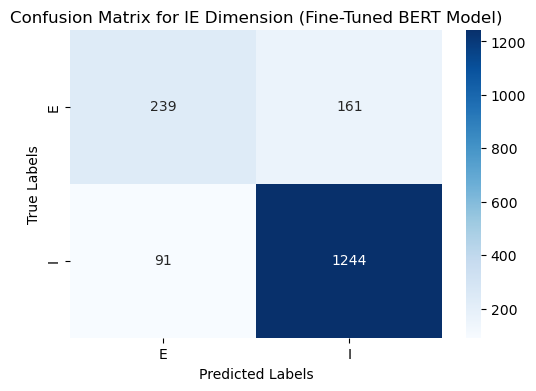


Processing MBTI dimension: NS

Training Logistic Regression on BERT embeddings for NS dimension...
BERT Embeddings + Logistic Regression Results for NS dimension:
Accuracy: 0.8582
F1 Score: 0.0611
Precision: 0.3478
Recall: 0.0335

Classification Report for BERT Embeddings + Logistic Regression Model (NS dimension):
               precision    recall  f1-score   support

           N       0.87      0.99      0.92      1496
           S       0.35      0.03      0.06       239

    accuracy                           0.86      1735
   macro avg       0.61      0.51      0.49      1735
weighted avg       0.79      0.86      0.80      1735


Training Fine-Tuned BERT model for NS dimension...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/olivia/Desktop/230_project/env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.369900,0.402738,0.878518,0.247721,0.687500,0.151079
2,0.345200,0.360034,0.879037,0.351740,0.605431,0.247874
3,0.343200,0.396500,0.859728,0.403974,0.461733,0.359058
4,0.282900,0.501198,0.874968,0.372719,0.554981,0.280576


Fine-Tuned BERT Model Results for NS dimension:
Accuracy: 0.8784
F1 Score: 0.2156
Precision: 0.9667
Recall: 0.1213

Classification Report for Fine-Tuned BERT Model (NS dimension):
               precision    recall  f1-score   support

           N       0.88      1.00      0.93      1496
           S       0.97      0.12      0.22       239

    accuracy                           0.88      1735
   macro avg       0.92      0.56      0.57      1735
weighted avg       0.89      0.88      0.84      1735



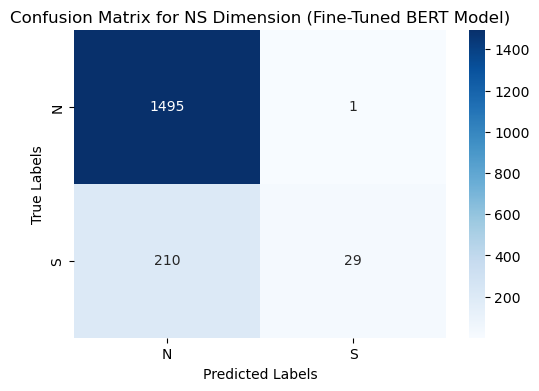


Processing MBTI dimension: TF

Training Logistic Regression on BERT embeddings for TF dimension...
BERT Embeddings + Logistic Regression Results for TF dimension:
Accuracy: 0.6767
F1 Score: 0.6452
Precision: 0.6497
Recall: 0.6407

Classification Report for BERT Embeddings + Logistic Regression Model (TF dimension):
               precision    recall  f1-score   support

           F       0.70      0.71      0.70       939
           T       0.65      0.64      0.65       796

    accuracy                           0.68      1735
   macro avg       0.67      0.67      0.67      1735
weighted avg       0.68      0.68      0.68      1735


Training Fine-Tuned BERT model for TF dimension...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/olivia/Desktop/230_project/env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.556500,0.543814,0.743192,0.696774,0.750662,0.650105
2,0.514900,0.552068,0.750911,0.722029,0.731516,0.712784
3,0.530500,0.556581,0.749436,0.721971,0.727220,0.716797


Fine-Tuned BERT Model Results for TF dimension:
Accuracy: 0.8121
F1 Score: 0.7681
Precision: 0.8852
Recall: 0.6784

Classification Report for Fine-Tuned BERT Model (TF dimension):
               precision    recall  f1-score   support

           F       0.77      0.93      0.84       939
           T       0.89      0.68      0.77       796

    accuracy                           0.81      1735
   macro avg       0.83      0.80      0.81      1735
weighted avg       0.82      0.81      0.81      1735



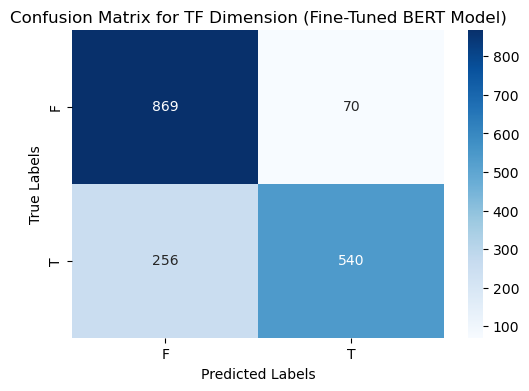


Processing MBTI dimension: JP

Training Logistic Regression on BERT embeddings for JP dimension...
BERT Embeddings + Logistic Regression Results for JP dimension:
Accuracy: 0.6259
F1 Score: 0.7152
Precision: 0.6621
Recall: 0.7777

Classification Report for BERT Embeddings + Logistic Regression Model (JP dimension):
               precision    recall  f1-score   support

           J       0.54      0.39      0.46       687
           P       0.66      0.78      0.72      1048

    accuracy                           0.63      1735
   macro avg       0.60      0.59      0.59      1735
weighted avg       0.61      0.63      0.61      1735


Training Fine-Tuned BERT model for JP dimension...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/olivia/Desktop/230_project/env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.556400,0.586832,0.676567,0.725711,0.735049,0.716606
2,0.561500,0.573840,0.712245,0.786536,0.705950,0.887890
3,0.505100,0.623726,0.702806,0.759023,0.735674,0.783901
4,0.448400,0.730130,0.706269,0.769503,0.723948,0.821175


Fine-Tuned BERT Model Results for JP dimension:
Accuracy: 0.7654
F1 Score: 0.8320
Precision: 0.7331
Recall: 0.9618

Classification Report for Fine-Tuned BERT Model (JP dimension):
               precision    recall  f1-score   support

           J       0.89      0.47      0.61       687
           P       0.73      0.96      0.83      1048

    accuracy                           0.77      1735
   macro avg       0.81      0.71      0.72      1735
weighted avg       0.79      0.77      0.74      1735



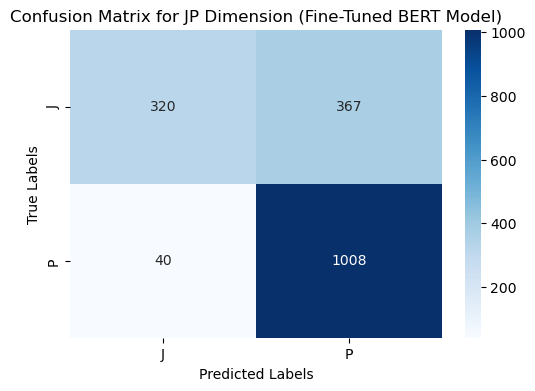

In [23]:
# Train models for each MBTI dimension
dimensions = ['IE', 'NS', 'TF', 'JP']
for dim in dimensions:
    print(f"\nProcessing MBTI dimension: {dim}")
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(mbti_df[dim])  # Convert labels to 0 and 1

    train_data, test_data, train_labels, test_labels = train_test_split(
        mbti_df['posts'], labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Train and evaluate baseline BERT model
    train_baseline_model(train_data, test_data, train_labels, test_labels, label_encoder, dim)

    # Train and evaluate Fine-Tuned BERT model
    train_bert_model(train_data, test_data, train_labels, test_labels, dim, label_encoder, num_epochs=10)
